# Extending the CUDA Target

## What is this?

Numba supports extending it to work with types it is not already aware of. This notebook presents the [Interval Example](http://numba.pydata.org/numba-doc/latest/extending/interval-example.html) from the documentation on Extending Numba, but working for CUDA.

## Why demo this?

It's not been possible to extend the CUDA target until recently.

* This demonstrates what works so far: adding new types and using them in CUDA
* Still to be completed: boxing and unboxing - passing in and out of CUDA kernels

## Use cases

* Add support in Numba CUDA for masked arrays
* Some class-like things (c.f. `Interval` example here)
* Awkward Arrays
* Your use case - please share ideas / wishes!

## Overview

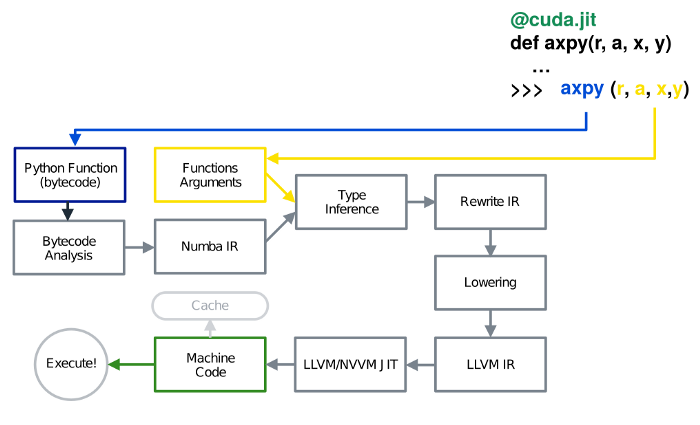

In [1]:
from IPython.core.display import Image
Image('pipeline.png')

Extensions are involved with the following pipeline stages:

- **Type inference:** Teaching Numba how to recognise and work with a new type
- **Data model:** Not strictly a stage, but provides a coupling between typing and lowering
- **Lowering:** Turning Numba IR into LLVM IR

## Some initial setup

Let's define an `Interval` class, for interval arithmetic:

In [2]:
class Interval(object):
    """ 
    A half-open interval on the real number line.
    """
    def __init__(self, lo, hi):
        self.lo = lo
        self.hi = hi

    def __repr__(self):
        return 'Interval(%f, %f)' % (self.lo, self.hi)

    @property
    def width(self):
        return self.hi - self.lo

## Typing

### Creating a new type

First we need a representation that Numba understands for the type of `Interval` objects. The base Numba type is `types.Type`:

In [3]:
from numba import types

class IntervalType(types.Type):
    def __init__(self):
        super().__init__(name='Interval')

We just need a single instance of the type object, so let's make it now:

In [4]:
interval_type = IntervalType()

### Associating the type with Python instances

To enable Numba to recognise instances of the `Interval` class as the `interval_type`, we register a function that takes an instance of `Interval`, and returns the Numba type :

In [5]:
from numba.core.extending import typeof_impl

@typeof_impl.register(Interval)
def typeof_interval(val, c): 
    return interval_type

The typing function takes two parameters. We don't need to use them here, but they are:

* `val`: the instance being typed. This can be useful if there are multiple Numba types for a given Python type, or if it is parameterized - e.g. a 1D array needs to be a different type to a 2D array.
* `c`: The *typeof context* - This can be ignored in most cases.

All `Interval` objects are the same type, so we can safely just return `interval_type` without inspecting `val`.

### Typing the constructor

When the constructor, `Interval(lo, hi)` is called, Numba needs to know what the return type will be. We register the typing for callables (like constructors) with:

In [6]:
from numba.core.extending import type_callable

@type_callable(Interval)
def type_interval(context):
    def typer(lo, hi):
        if isinstance(lo, types.Float) and isinstance(hi, types.Float):
            return interval_type
    return typer

The typer can return:

* A Numba type, if the typing is successful
* `None`, if the typing is unsuccessful.
  - If the typing is unsuccessful, that doesn't result in an immediate error - Numba could try other registered typing functions to see if any of those will successfully return a type.

We've restricted construction of `Interval` objects in jitted functions to using floats for the bounds of the interval, keeping things simple for now.

## The Data Model

The *Data model* couples Numba's front end with the LLVM backend, from a typing perspective - each model registered with Numba contains a description of the structure of the type in terms of more primitive types, which can be mapped more directly to LLVM types.

There are various models that make a good starting point for defining a model for a custom class - we'll use the `StructModel`, since the representation of an `Interval` instance is a bit like a struct of two floats.

To use the `StructModel`, we provide a list of the members of the struct and their types:

In [7]:
from numba.core.extending import models, register_model

@register_model(IntervalType)
class IntervalModel(models.StructModel):
    def __init__(self, dmm, fe_type):
        members = [
            ('lo', types.float64),
            ('hi', types.float64),
            ]
        models.StructModel.__init__(self, dmm, fe_type, members)

## Lowering

### Attribute access

Numba provides a quick way to expose the attributes of a struct without us having to write code to generate the LLVM IR to access the data - this is `make_attribute_wrapper`:

In [8]:
from numba.core.extending import make_attribute_wrapper

make_attribute_wrapper(IntervalType, 'lo', 'lo')
make_attribute_wrapper(IntervalType, 'hi', 'hi')

### Implementing the constructor

To lower a function, we need to generate the LLVM IR that implements it. We need to register a function with Numba that does this generation. The implementation for lowering the Interval constructor follows:

In [9]:
from numba.core.extending import lower_builtin
from numba.core import cgutils

@lower_builtin(Interval, types.Float, types.Float)
def impl_interval(context, builder, sig, args):
    typ = sig.return_type
    lo, hi = args
    interval = cgutils.create_struct_proxy(typ)(context, builder)
    interval.lo = lo
    interval.hi = hi
    return interval._getvalue()

An explanation of each part of the implementation:
    
* The `@lower_builtin` decorator decorates the function for a typing given as parameters to the decorator. The function called is first, followed by the types of its arguments.
* The implementation function is always called with four arguments:
  - `context`: The *typing context* - this can be used to generate values and casts appropriate to the target.
  - `builder`: An llvmlite IR builder, used for generating IR directly.
  - `sig`: The signature of the function, consisting of the return type and argument types (and the type of the receiver, for methods). We only need the return type here.
  - `args`: The arguments to the function, as LLVM IR generated previously.
* `cgutils` is a library of code generation utilities.
  - Rather than fiddling around directly creating a struct and manipulating it directly, we use the `create_struct_proxy` method to create an object that generates the struct, and allows us to generate IR that manipulates it.
  - We can treat the struct proxy a bit like a Python object, assigning `lo` to `interval.lo` generates the IR that assigns the IR `lo` value to the IR for the struct proxy.
* We don't actually want a struct proxy object to come out of this function - Numba is expecting an IR node - we get this with the `_getvalue()` method.

#### IR dump

You can dump IR with the environment variable `NUMBA_DUMP_LLVM=1`. Some excerpts of IR generated by `impl_interval` look like:

For `interval = cgutils.create_struct_proxy(typ)(context, builder)`:

```
  %"x" = alloca {double, double}
  store {double, double} zeroinitializer, {double, double}* %"x"
```

For `interval.lo = lo`:

```
  %"$const4.1" = alloca double
  store double 0x3ff0000000000000, double* %"$const4.1"
  %".12" = load double, double* %"$const4.1"
  %".17" = getelementptr inbounds {double, double}, {double, double}* %".14", i32 0, i32 0
  store double %".12", double* %".17"
```

For `interval.hi = hi`:

```
  %"$const6.2" = alloca double
  store double 0x4008000000000000, double* %"$const6.2"
  %".13" = load double, double* %"$const6.2"
  %".19" = getelementptr inbounds {double, double}, {double, double}* %".14", i32 0, i32 1
  store double %".13", double* %".19"
```

Generated IR is very verbose and contains a lot of redundancy - a lot of this is optimized to something simpler by LLVM later.

### Implementing an attribute

The example in the Numba documentation makes this very easy, with:

```python
@overload_attribute(IntervalType, "width")
def get_width(interval):
    def getter(interval):
        return interval.hi - interval.lo
    return getter
```

Which allows the implementation of the attribute to be written in Python that then gets jitted (rather than having to write IR manually) - however, `@overload` doesn't work for the CUDA target yet, so we need to use some more low-level APIs, and directly interact with registries in the CUDA target.

#### Typing

We register all the attributes of a type in a single class. The type is identified by the `key` property:

In [10]:
from numba.core.typing.templates import AttributeTemplate
from numba.cuda.cudadecl import registry as cuda_registry

@cuda_registry.register_attr
class Interval_attrs(AttributeTemplate):
    key = IntervalType

    def resolve_width(self, mod):
        return types.float64

Each attribute is typed by a `resolve_<attr>` function, which returns the type of the attribute. We only have one attribute to resolve here.

#### Lowering

Lowering an attribute is similar to the `@lower_builtin` decorator we used above, but we'll use the `@lower_attr` decorator instead (I usually rename it to `@cuda_lower_attr` to avoid confusion with other `@lower_attr` things in Numba): 

In [11]:
from numba.cuda.cudaimpl import lower_attr as cuda_lower_attr

@cuda_lower_attr(IntervalType, 'width')
def cuda_Interval_width(context, builder, sig, arg):
    lo = builder.extract_value(arg, 0)
    hi = builder.extract_value(arg, 1)
    return builder.fsub(hi, lo)

The code above builds the IR to get the 0 (`lo`) and 1 (`hi`) elements out of its argument, and then subtract them with the `fsub` instruction. The generated IR (abridged) may look like):

```
  %".49" = load {double, double}, {double, double}* %"x"
  %".50" = extractvalue {double, double} %".49", 0
  %".51" = extractvalue {double, double} %".49", 1
  %".52" = fsub double %".51", %".50"
  %".54" = load double, double* %"$14load_attr.5"
  store double %".52", double* %"$14load_attr.5"
```

## Trying it out

In [12]:
from numba import cuda, njit
import numpy as np

First let's define some `@njit` functions that we'll call from a kernel:

In [13]:
@njit
def inside_interval(interval, x):
    """Tests attribute access"""
    return interval.lo <= x < interval.hi


@njit
def interval_width(interval):
    """Tests property access"""
    return interval.width


@njit
def sum_intervals(i, j):
    """Tests the Interval constructor"""
    return Interval(i.lo + j.lo, i.hi + j.hi)

Now we'll create a kernel that uses them:

In [14]:
@cuda.jit
def kernel(arr):
    x = Interval(1.0, 3.0)
    arr[0] = x.hi + x.lo
    arr[1] = x.width
    arr[2] = inside_interval(x, 2.5)
    arr[3] = inside_interval(x, 3.5)
    arr[4] = interval_width(x)

    y = Interval(7.5, 9.0)
    z = sum_intervals(x, y)
    arr[5] = z.lo
    arr[6] = z.hi

And call it:

In [15]:
out = np.zeros(7)

kernel[1, 1](out)

# Should print: [ 4.   2.   1.   0.   2.   8.5 12. ]
out

array([ 4. ,  2. ,  1. ,  0. ,  2. ,  8.5, 12. ])

## Further info:

* Discussion with Jim Pivarski on the Numba Discourse: https://numba.discourse.group/t/making-awkward-arrays-work-in-the-cuda-target/63
* The Interval example: http://numba.pydata.org/numba-doc/latest/extending/interval-example.html#type-inference-for-python-values
* More examples:
  - Lots of typing functions in here: https://github.com/numba/numba/blob/master/numba/cuda/cudadecl.py
  - Lots of lowering functions: https://github.com/numba/numba/blob/master/numba/cuda/cudaimpl.py